In [1]:
!nvidia-smi
# Just for checking GPU

Mon Jan  5 07:35:26 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [16]:
!pip install segment-anything opencv-python matplotlib torch torchvision
# Installing YOLOv8

In [18]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth


--2026-01-05 07:51:17--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.238.103, 13.35.238.71, 13.35.238.113, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.238.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M  29.8MB/s    in 5.2s    

2026-01-05 07:51:23 (69.2 MB/s) - ‘sam_vit_b_01ec64.pth’ saved [375042383/375042383]



In [19]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

sam_checkpoint = "sam_vit_b_01ec64.pth"  # download once
sam = sam_model_registry["vit_b"](checkpoint=sam_checkpoint)
sam.to("cuda" if torch.cuda.is_available() else "cpu")

mask_generator = SamAutomaticMaskGenerator(sam)


In [5]:
from google.colab import files
uploaded = files.upload()


Saving img1_43_nosy.jpg to img1_43_nosy.jpg


In [20]:
image = cv2.imread("img1_43_nosy.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


In [22]:
masks = mask_generator.generate(image_rgb)
print("Raw masks detected:", len(masks))


Raw masks detected: 51


In [39]:
areas = np.array([m["area"] for m in masks])
median_area = np.median(areas)

min_area = 0.3 * median_area
max_area = 2.0 * median_area

candidates = [m for m in masks if min_area < m["area"] < max_area]


In [41]:
def iou(mask1, mask2):
    inter = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return inter / union

def containment(mask_small, mask_large):
    inter = np.logical_and(mask_small, mask_large).sum()
    return inter / mask_small.sum()   # % of small mask inside large


In [42]:
final_masks = []

for m in sorted(candidates, key=lambda x: x["area"], reverse=True):
    keep = True
    for fm in final_masks:
        # suppress duplicates
        if iou(m["segmentation"], fm["segmentation"]) > 0.6:
            keep = False
            break

        # suppress contained masks (head/body duplicates)
        if containment(m["segmentation"], fm["segmentation"]) > 0.8:
            keep = False
            break

    if keep:
        final_masks.append(m)

print("Final screw count:", len(final_masks))


Final screw count: 42


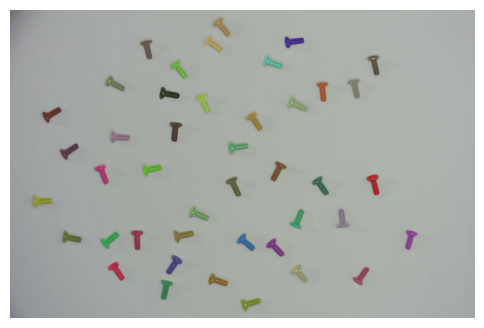

In [43]:
overlay = image_rgb.copy()

for m in final_masks:
    seg = m["segmentation"]
    color = np.random.randint(0,255,3)
    overlay[seg] = overlay[seg]*0.5 + color*0.5

plt.figure(figsize=(6,6))
plt.imshow(overlay.astype(np.uint8))
plt.axis("off")
plt.show()


In [45]:
ground_truth = 43
predicted = len(final_masks)   # from AI model

accuracy = 1 - abs(predicted - ground_truth) / ground_truth
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 97.67%
